In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tushare as ts
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [4]:
data = pd.read_csv('./人口-预期寿命-GDP.csv')

In [23]:
data = data[data['country'] == 'China']

In [24]:
data

,country,year,population,continent,life_exp,gdp_cap
288,China,1952,556263527,Asia,44.00000,400.448611
289,China,1957,637408000,Asia,50.54896,575.987001
290,China,1962,665770000,Asia,44.50136,487.674018
291,China,1967,754550000,Asia,58.38112,612.705693
292,China,1972,862030000,Asia,63.11888,676.900092
293,China,1977,943455000,Asia,63.96736,741.237470
294,China,1982,1000281000,Asia,65.52500,962.421381
295,China,1987,1084035000,Asia,67.27400,1378.904018
296,China,1992,1164970000,Asia,68.69000,1655.784158
297,China,1997,1230075000,Asia,70.42600,2289.234136


In [25]:
gdp_year_data = data.loc[::-1, ['year', 'gdp_cap']]

In [26]:
gdp_year_data

,year,gdp_cap
299,2007,4959.114854
298,2002,3119.280896
297,1997,2289.234136
296,1992,1655.784158
295,1987,1378.904018
294,1982,962.421381
293,1977,741.237470
292,1972,676.900092
291,1967,612.705693
290,1962,487.674018


In [27]:
gdp_year_data = gdp_year_data.set_index('year')

In [28]:
gdp_year_data

,gdp_cap
year,
2007,4959.114854
2002,3119.280896
1997,2289.234136
1992,1655.784158
1987,1378.904018
1982,962.421381
1977,741.237470
1972,676.900092
1967,612.705693


In [29]:
gdp_series = gdp_year_data['gdp_cap']

In [30]:
gdp_series.head()

year
2007    4959.114854
2002    3119.280896
1997    2289.234136
1992    1655.784158
1987    1378.904018
Name: gdp_cap, dtype: float64

In [31]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries[::10], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

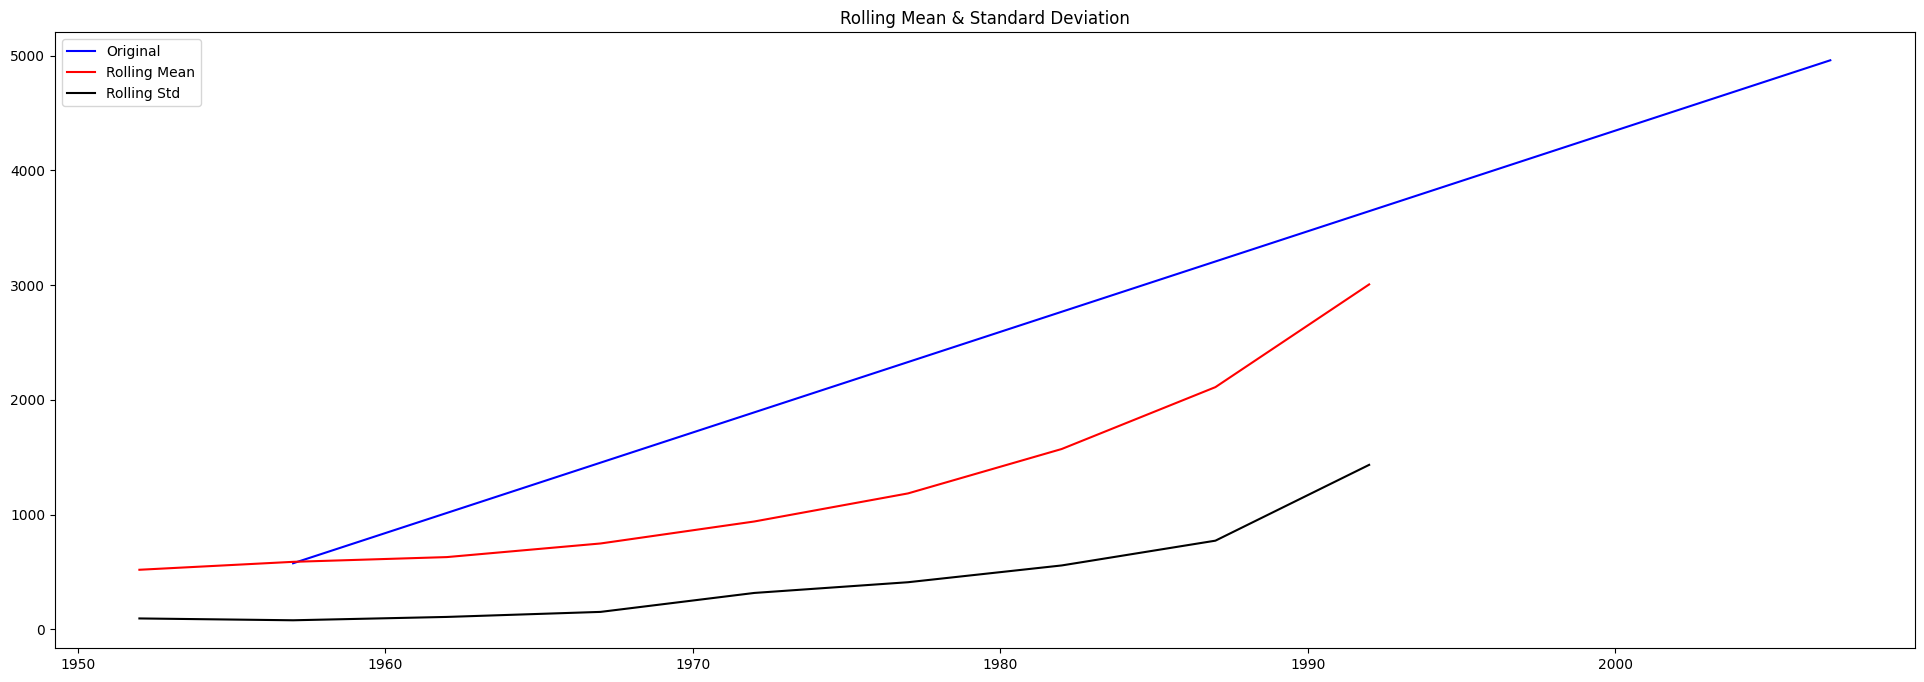

Results of Dickey-Fuller Test:
Test Statistic                -1.768242
p-value                        0.396339
#Lags Used                     4.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


In [32]:
test_stationarity(gdp_series)